##### Importando as bibliotecas e Preparando os dados


In [1]:
# Importando as bibliotecas
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import os
import seaborn as sns

# Bibliotecas para o Tensorflow e Keras
import tensorflow as tf
from keras.utils import to_categorical
from keras.utils import img_to_array, load_img
from keras import models, layers

# Bibliotecas para o modelo de rede neural convolucional
from keras.applications import VGG19
from keras.applications.vgg19 import preprocess_input

# Bibliotecas para avaliação do modelo
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support

tf.get_logger().setLevel('ERROR')


In [2]:
# Declarando variáveis

# Caminho dos datasets
path = './chest_xray/'
normal_classe = 'NORMAL'
pneumonia_classe = 'PNEUMONIA'

# Treino
treinamento_folder = os.path.join(path, 'train/')
treinamento_normal_dir = os.path.join(treinamento_folder, normal_classe)
treinamento_pneumonia_dir = os.path.join(treinamento_folder, pneumonia_classe)

# Teste
teste_folder = os.path.join(path, 'test/')
teste_normal_dir = os.path.join(teste_folder, normal_classe)
teste_pneumonia_dir = os.path.join(teste_folder, pneumonia_classe)

# Validação
validacao_folder = os.path.join(path, 'val/')
validacao_normal_dir = os.path.join(validacao_folder, normal_classe)
validacao_pneumonia_dir = os.path.join(validacao_folder, pneumonia_classe)

# Tamanho das imagens
img_width = 196
img_height = 196

# Variáveis para o treinamento
batch_size = 32
epochs = 100


In [3]:
# Checando se os nomes das classes são iguais

class_names = os.listdir(treinamento_folder)

if class_names == os.listdir(teste_folder) == os.listdir(validacao_folder):
    print("Nome das classes: %s" % (class_names))
else:
    raise Exception("Nome das classes não são iguais.")


Nome das classes: ['NORMAL', 'PNEUMONIA']


In [4]:
# Análise dos diretórios de treino, teste e validação e criando dataframes para cada um deles

# Procurando todas as imagens nos diretórios com extensão jpeg
treinamento_normal_cases = glob.glob(treinamento_normal_dir + '/*jpeg')
treinamento_pneumonia_cases = glob.glob(treinamento_pneumonia_dir + '/*jpeg')

teste_normal_cases = glob.glob(teste_normal_dir + '/*jpeg')
teste_pneumonia_cases = glob.glob(teste_pneumonia_dir + '/*jpeg')

validacao_normal_cases = glob.glob(validacao_normal_dir + '/*jpeg')
validacao_pneumonia_cases = glob.glob(validacao_pneumonia_dir + '/*jpeg')

# Criando listas para os casos de treino, teste e validação
treinamento_list = []
teste_list = []
validacao_list = []

for x in treinamento_normal_cases:
    treinamento_list.append([x, normal_classe])

for x in treinamento_pneumonia_cases:
    treinamento_list.append([x, pneumonia_classe])

for x in teste_normal_cases:
    teste_list.append([x, normal_classe])

for x in teste_pneumonia_cases:
    teste_list.append([x, pneumonia_classe])

for x in validacao_normal_cases:
    validacao_list.append([x, normal_classe])

for x in validacao_pneumonia_cases:
    validacao_list.append([x, pneumonia_classe])

# Criando dataframes
treinamento_df = pd.DataFrame(treinamento_list, columns=[
                              'IMAGE', 'DIAGNOSTICO'])
teste_df = pd.DataFrame(teste_list, columns=['IMAGE', 'DIAGNOSTICO'])
validacao_df = pd.DataFrame(validacao_list, columns=['IMAGE', 'DIAGNOSTICO'])


Text(0.5, 1.0, 'DADOS DE VALIDAÇÃO')

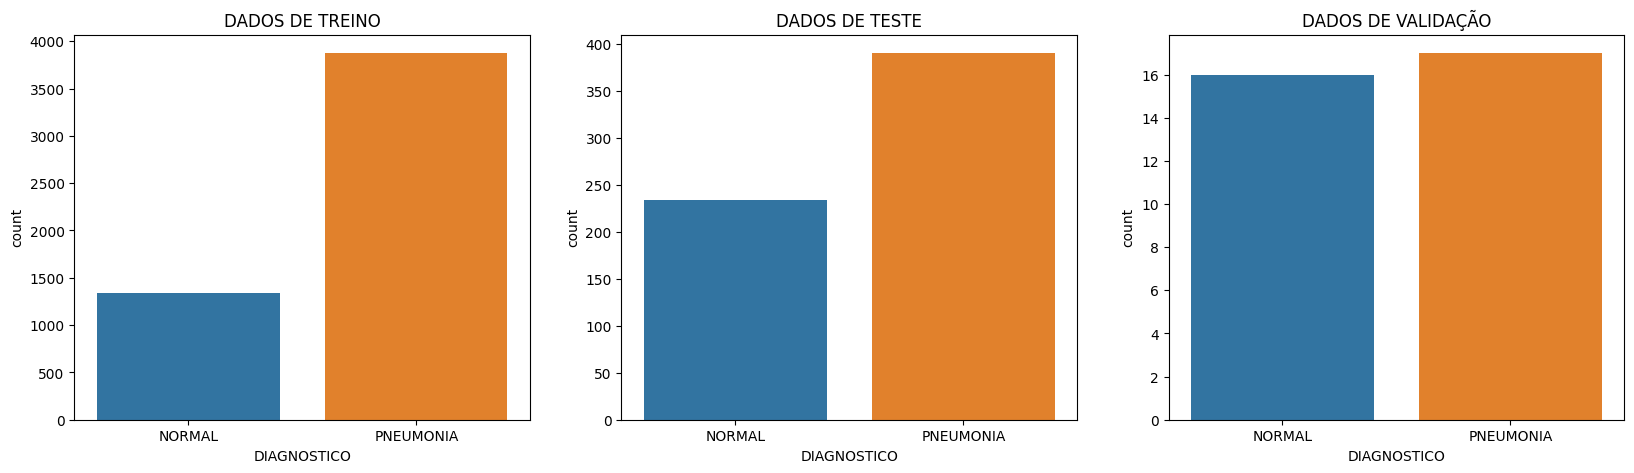

In [5]:
# Plotando informações dos dados de treino, teste e validação

plt.figure(figsize=(20, 5))

plt.subplot(1, 3, 1)
sns.countplot(x=treinamento_df['DIAGNOSTICO'])
plt.title('DADOS DE TREINO')

plt.subplot(1, 3, 2)
sns.countplot(x=teste_df['DIAGNOSTICO'])
plt.title('DADOS DE TESTE')

plt.subplot(1, 3, 3)
sns.countplot(x=validacao_df['DIAGNOSTICO'])
plt.title('DADOS DE VALIDAÇÃO')


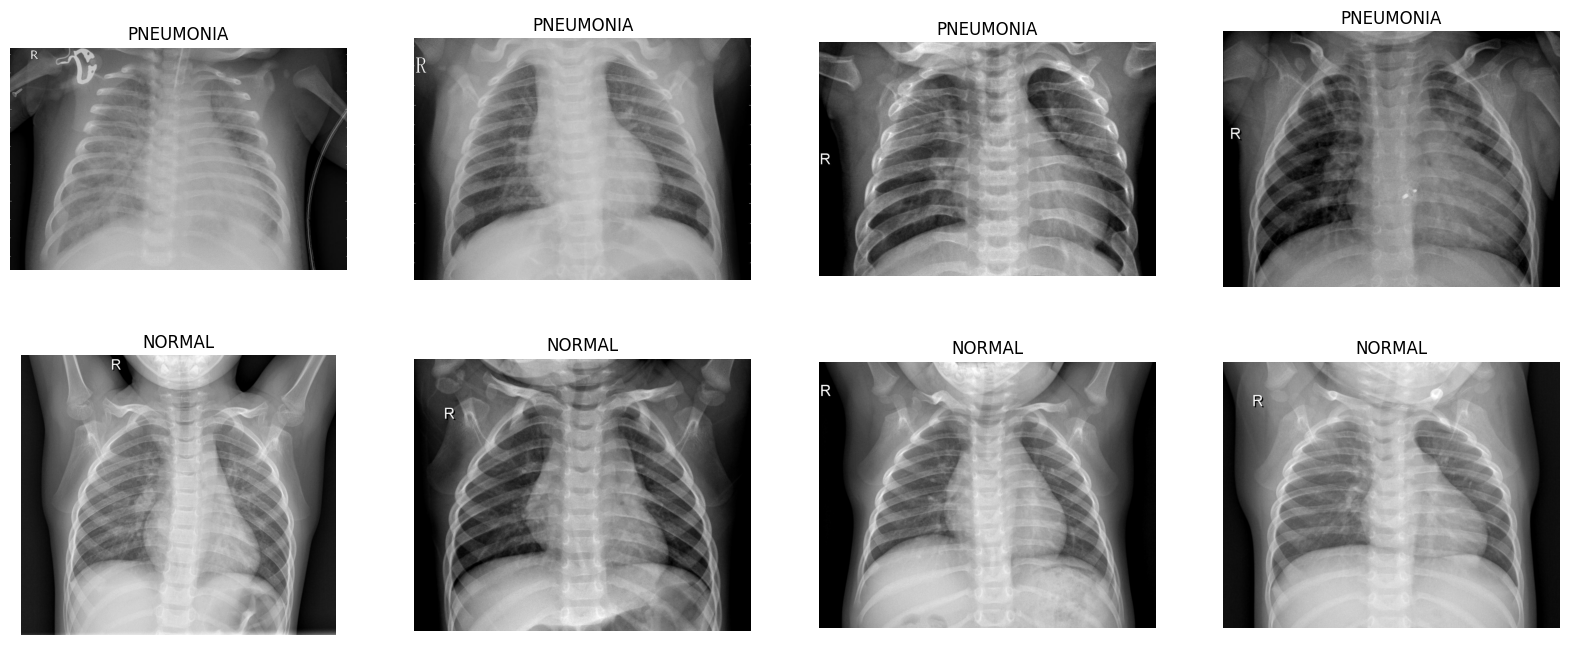

In [49]:
# Plotando imagens brutas apenas para revisão

plt.figure(figsize=(20, 8))
for i, img_path in enumerate(treinamento_df[treinamento_df['DIAGNOSTICO'] == pneumonia_classe][0:4]['IMAGE']):
    plt.subplot(2, 4, i+1)
    plt.axis('off')
    img = plt.imread(img_path)
    plt.imshow(img, cmap='gray')
    plt.title(pneumonia_classe)

for i, img_path in enumerate(treinamento_df[treinamento_df['DIAGNOSTICO'] == normal_classe][0:4]['IMAGE']):
    plt.subplot(2, 4, 4+i+1)
    plt.axis('off')
    img = plt.imread(img_path)
    plt.imshow(img, cmap='gray')
    plt.title(normal_classe)


In [7]:
# Funções para pré-processamento das imagens

def prepare_image(image_path):
    img = load_img(image_path, target_size=(img_width, img_height))

    # Convertendo para array
    img = img_to_array(img)

    # Transfer Learning: Esta esta etapa é para aplicar o pré-processamento do modelo
    # de transferência de aprendizado em nossas imagens antes de passá-las para o modelo
    img = preprocess_input(img)

    return img


def prepare_folder(path):
    image_list = []
    image_labels = []

    for folder in os.listdir(path):

        # Pegando todas as imagens de cada pasta
        image_files = os.listdir(os.path.join(path, folder))

        print("Preparando dataset %s, com o tamanho total de  %d" %
              (folder, len(image_files)))

        for img_name in image_files:
            image_path = os.path.join(path, folder, img_name)

            # Pré processando as imagens
            img = prepare_image(image_path)

            # Adicionando imagens e labels para as listas
            image_list.append(img)
            image_labels.append(class_names.index(folder))

    labels = to_categorical(image_labels)
    images = np.array(image_list)

    return images, labels


In [8]:
# Preparando os dados de imagem de treinamento, validação e teste (matriz de imagem e nome da classe) para processamento

treino_x, treino_y = prepare_folder(treinamento_folder)
validacao_x, validacao_y = prepare_folder(validacao_folder)
teste_x, teste_y = prepare_folder(teste_folder)


Preparando dataset NORMAL, com o tamanho total de  1341
Preparando dataset PNEUMONIA, com o tamanho total de  3875
Preparando dataset NORMAL, com o tamanho total de  16
Preparando dataset PNEUMONIA, com o tamanho total de  17
Preparando dataset NORMAL, com o tamanho total de  234
Preparando dataset PNEUMONIA, com o tamanho total de  390


##### Funções auxiliares


In [95]:
# Função para plotar gráficos de acurácia e loss do modelo
def plot_model(history):
    print('Plotando gráficos de acurácia e loss do modelo')
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(len(accuracy))

    plt.gcf().clear()
    plt.figure(figsize=(15, 8))

    plt.subplot(1, 2, 1)
    plt.title('Acurácia (Treinamento e Validação)')
    plt.plot(epochs_range, accuracy, label='Training Accuracy')
    plt.plot(epochs_range, val_accuracy, label='Validation Accuracy')
    plt.legend(loc='lower right')

    plt.subplot(1, 2, 2)
    plt.title('Perda (Treinamento e Validação)')
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='lower right')


In [10]:
# Funções para plotar a imagem e a previsão

# Essa função plota a imagem fornecida em array pegando o índice e 3 arrays,
# o array de previsão, array de rótulo verdadeiro e array de imagem
def plot_image(i, predictions_array, true_label, img):
    predictions_array, true_label, img = predictions_array[i], true_label[i], img[i]

    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    plt.imshow(img.astype('int32'))

    predicted_label = np.argmax(predictions_array)
    true_label = np.argmax(true_label)

    if predicted_label == true_label:  # setting up label color
        color = 'green'  # correct then blue colour
    else:
        color = 'red'  # wrong then red colour

    plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label], 100*np.max(
        predictions_array), class_names[true_label]), color=color)


# Essa função plota o gráfico de barras fornecido no array de dados
# pegando o índice junto com os arrays de previsão e rótulo verdadeiro
def plot_value_array(i, predictions_array, true_label):
    predictions_array, true_label = predictions_array[i], true_label[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    predicted_label = np.argmax(predictions_array)
    true_label = np.argmax(true_label)

    predicted_label = predicted_label + 1
    true_label = true_label + 1

    thisplot = plt.bar(range(2), predicted_label, color='seashell')
    plt.ylim([0, 1])

    thisplot[0].set_label(normal_classe)
    thisplot[1].set_label(pneumonia_classe)

    thisplot[predicted_label-1].set_color('red')
    thisplot[true_label-1].set_color('green')


# Essa função plota 16 imagens aleatórias do dataset com suas previsões
# e gráficos de barras junto com o rótulo verdadeiro e porcentagem da previsão
def plot_results(predictions, image_label, images, title='Results'):
    num_rows = 4
    num_cols = 4
    num_images = num_rows*num_cols

    plt.figure(figsize=(2*2*num_cols, 2*num_rows))
    plt.suptitle(title, fontsize=16)

    all_indexes_prediction_list = list(range(len(predictions)))

    def find_indexer():
        indexer = random.choice(all_indexes_prediction_list)
        all_indexes_prediction_list.remove(indexer)
        return indexer

    for i in range(num_images):
        if len(all_indexes_prediction_list) == 0:
            break
        indexer = find_indexer()

        plt.subplot(num_rows, 2*num_cols, 2*i+1)
        plot_image(indexer, predictions, image_label, images)

        plt.subplot(num_rows, 2*num_cols, 2*i+2)
        plot_value_array(indexer, predictions, image_label)

    plt.subplots_adjust(hspace=0.5)
    plt.show()


##### Criação e treinamento do modelo


In [11]:
# Modelagem COM Transferência de Aprendizado
# Aqui vamos preparar o modelo de acordo com nossos requisitos

# Vamos preparar nossa camada de entrada para passar o tamanho da imagem. o padrão é (224,224,3). vamos alterá-lo para o tamanho da imagem que estamos usando.
input_layer = layers.Input(shape=(img_width, img_height, 3))

# Inicializando o modelo de transferência  com as propriedades apropriadas para nossas necessidades.
# Estamos passando parâmetros como:
# 1) weights='imagenet' - Usando isso, estamos carregando os pesos como os pesos originais.
# 2) input_tensor para passar o modelo usando input_tensor
# 3) Queremos alterar a última camada, então não estamos incluindo a camada superior

model_tl = VGG19(
    weights='imagenet', input_tensor=input_layer, include_top=False)

# Visualizando o sumário do modelo com nossas propriedades.
model_tl.summary()


Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 196, 196, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 196, 196, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 196, 196, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 98, 98, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 98, 98, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 98, 98, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 49, 49, 128)       0     

In [12]:
# Acessando a última camada do modelo e adicionando Flatten e Dense após ela

# Ultima camada do modelo
last_layer = model_tl.output

# Adicionando uma camada Flatten
flatten = layers.Flatten()(last_layer)

# Adicionando uma camada Dense para a camada de saída final
output_layer = layers.Dense(2, activation='softmax')(flatten)

# Criando o modelo com a camada de entrada e a camada de saída
model = models.Model(inputs=input_layer, outputs=output_layer)

# Sumário do modelo final com as camadas adicionadas
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 196, 196, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 196, 196, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 196, 196, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 98, 98, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 98, 98, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 98, 98, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 49, 49, 128)       0     

In [13]:
# Congelando todas as camadas, exceto a última camada para impedir que o modelo de transferência do conhecimento seja treinado novamente

for layer in model.layers[:-1]:
    layer.trainable = False
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 196, 196, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 196, 196, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 196, 196, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 98, 98, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 98, 98, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 98, 98, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 49, 49, 128)       0     

In [14]:
# Data Augmentation

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
    tf.keras.layers.experimental.preprocessing.RandomZoom(0.2),

])

model = tf.keras.Sequential([
    data_augmentation,
    model
])


In [15]:
# Compilação do modelo
model.compile(loss='categorical_crossentropy',
              optimizer='Adam', metrics=['accuracy'])


In [16]:
# Treinamento do modelo

from keras import callbacks

# Monitora a perda de validação e interrompe o treinamento quando a perda
# de validação não melhora por 5 épocas consecutivas para evitar overfitting
earlystopping = callbacks.EarlyStopping(monitor="val_loss",
                                        mode="min", patience=5,
                                        restore_best_weights=True)

history = model.fit(
    treino_x,
    treino_y,
    epochs=epochs,
    batch_size=batch_size,
    verbose=True,
    validation_data=(validacao_x, validacao_y),
    callbacks=[earlystopping]
)


Epoch 1/100
163/163 [==============================] - 46s 209ms/step - loss: 1.2314 - accuracy: 0.9381 - val_loss: 0.1786 - val_accuracy: 0.9697
Epoch 2/100
163/163 [==============================] - 33s 202ms/step - loss: 0.3658 - accuracy: 0.9751 - val_loss: 0.0021 - val_accuracy: 1.0000
Epoch 3/100
163/163 [==============================] - 33s 204ms/step - loss: 0.5527 - accuracy: 0.9739 - val_loss: 0.3230 - val_accuracy: 0.9697
Epoch 4/100
163/163 [==============================] - 34s 208ms/step - loss: 0.4553 - accuracy: 0.9793 - val_loss: 0.2759 - val_accuracy: 0.9697
Epoch 5/100
163/163 [==============================] - 37s 226ms/step - loss: 0.3936 - accuracy: 0.9812 - val_loss: 0.7096 - val_accuracy: 0.9394
Epoch 6/100
163/163 [==============================] - 35s 214ms/step - loss: 0.3274 - accuracy: 0.9852 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 7/100
163/163 [==============================] - 36s 222ms/step - loss: 0.1850 - accuracy: 0.9900 - val_loss: 8.69

Plotando gráficos de acurácia e loss do modelo


<Figure size 640x480 with 0 Axes>

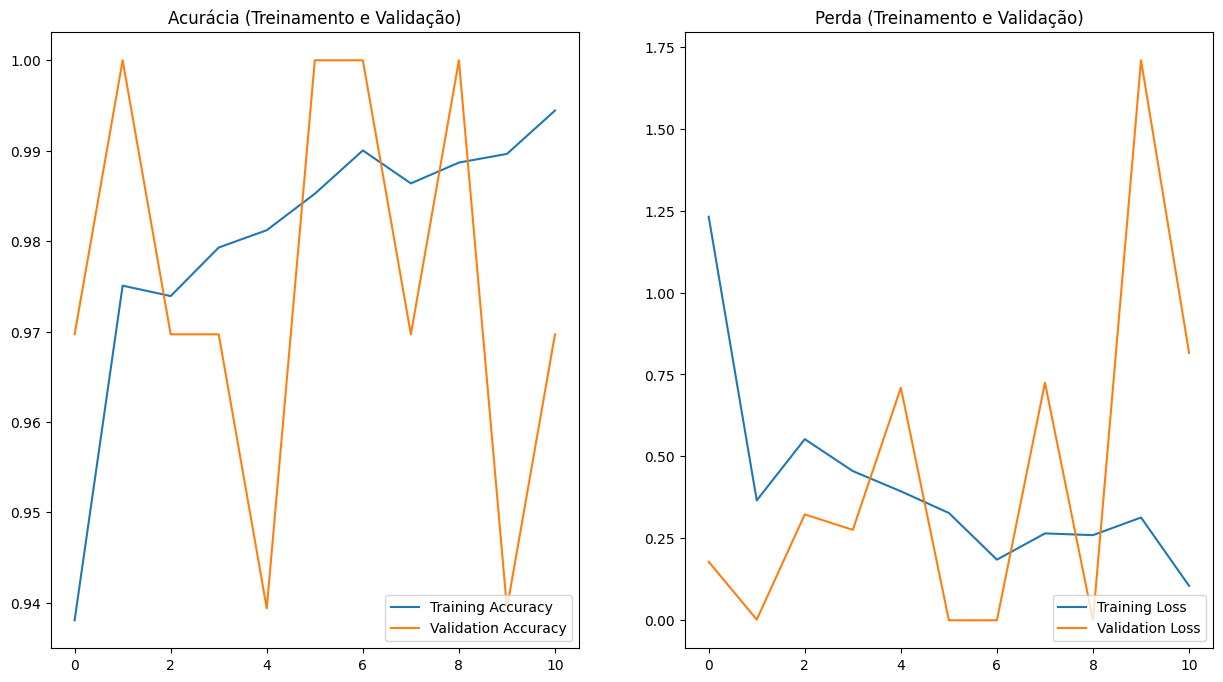

In [96]:
# model.save('models/chest_xray_tcc.h5')

plot_model(history)

##### Validação do modelo


In [19]:
# Preparando array de previsões para os dados de teste e validação
validacao_predictions = model.predict(validacao_x)
teste_predictions = model.predict(teste_x)


20/20 [==============================] - 5s 242ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

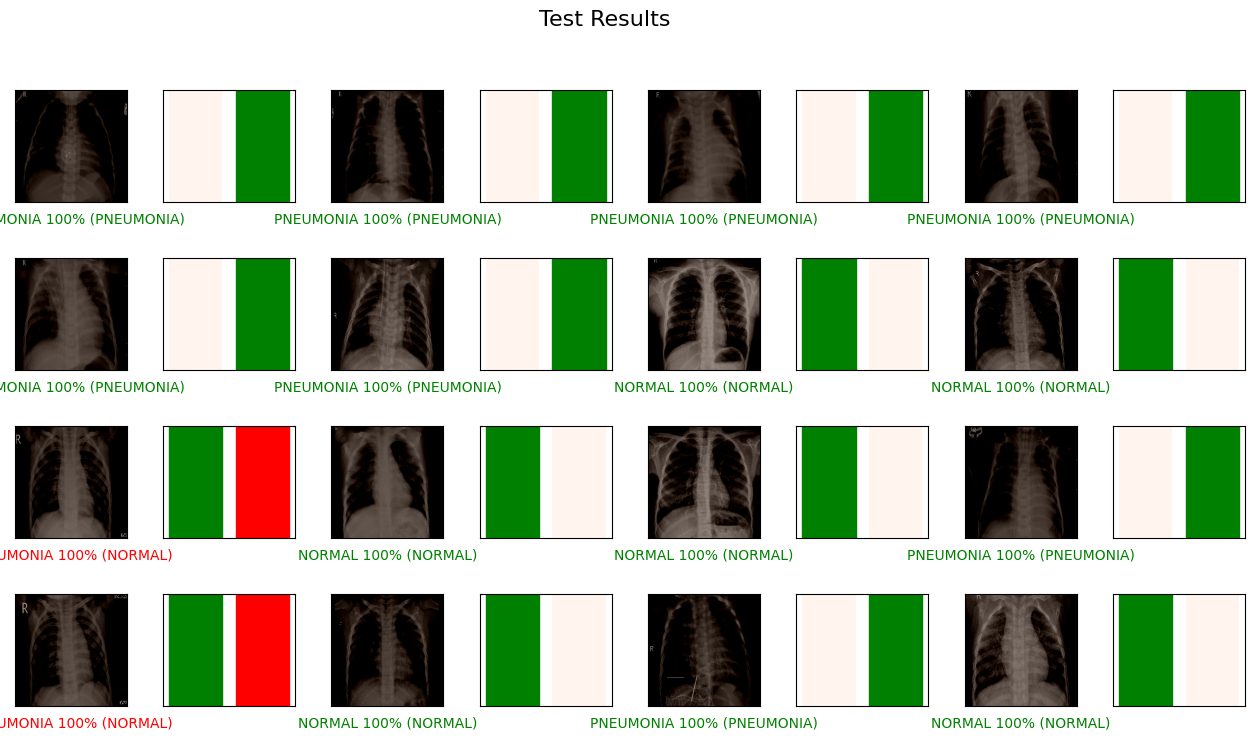

In [20]:
# Previsão nas imagens de teste
plot_results(
    teste_predictions,
    teste_y,
    teste_x,
    title='Test Results'
)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

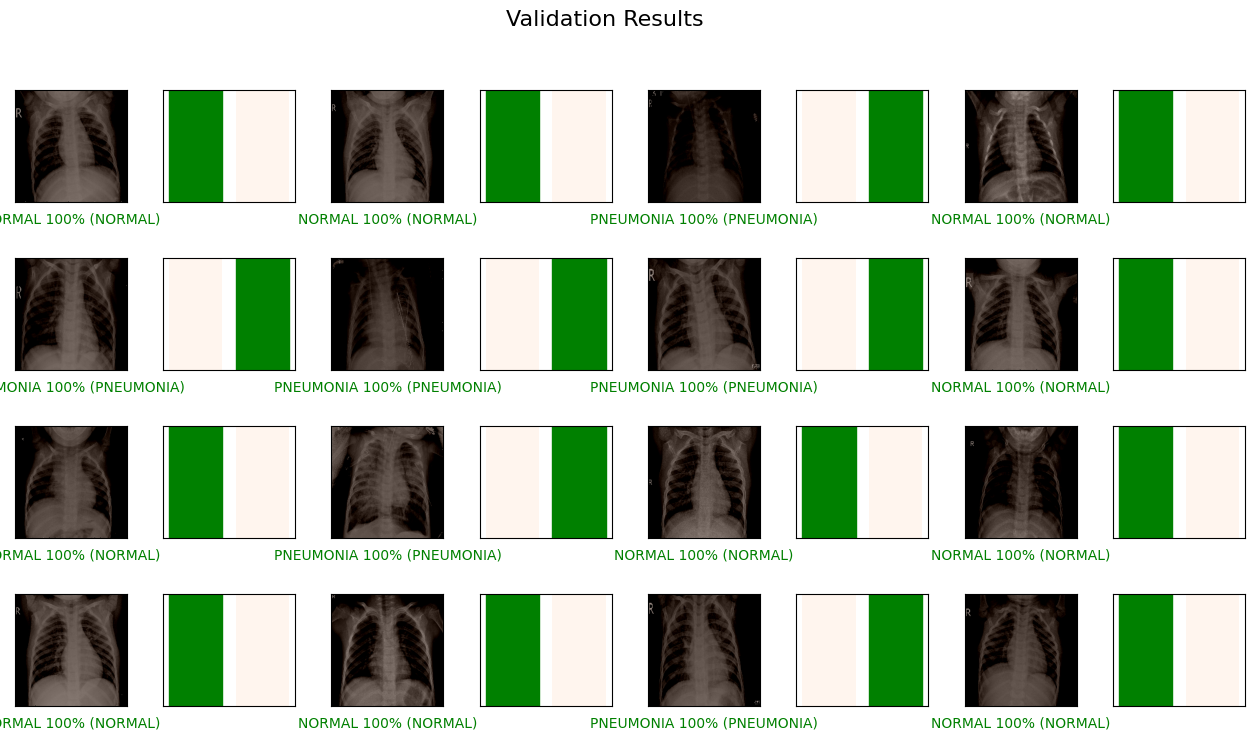

In [21]:
# Previsão nas imagens de validação
plot_results(
    validacao_predictions,
    validacao_y,
    validacao_x,
    title='Validation Results'
)


Porcentagem de acerto: 100%
Porcentagem de acerto: 86%


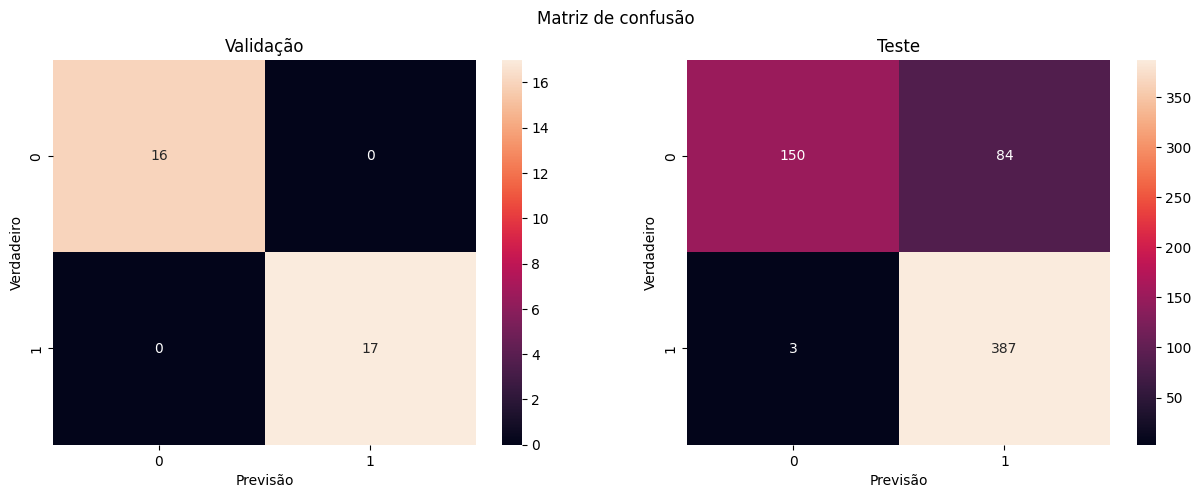

In [103]:
# Matriz de confusão

plt.figure(figsize=(15, 5))
plt.suptitle("Matriz de confusão")


def get_confusion_matrix(predictions, labels):
    # Convertendo rótulos preditos em array categorico
    predictions_classes = np.argmax(predictions, axis=1)

    # Convertendo previsões em array com o maior valor
    Y_true = np.argmax(labels, axis=1)

    # Matriz de confusão
    matrix = confusion_matrix(Y_true, predictions_classes)

    porcentagem_acerto = (
        Y_true == predictions_classes).sum() / len(Y_true) * 100

    print(f'Porcentagem de acerto: {round(porcentagem_acerto)}%')

    return matrix


def plot_confusion_matrix(predictions, labels, title='Confusion Matrix', i=1):
    plt.subplot(1, 2, i)

    matrix = get_confusion_matrix(predictions, labels)

    sns.heatmap(matrix, annot=True, fmt='g')

    plt.xlabel("Previsão")
    plt.ylabel("Verdadeiro")
    plt.title(title)


plot_confusion_matrix(validacao_predictions, validacao_y,
                      title='Validação', i=1)
plot_confusion_matrix(teste_predictions, teste_y, title='Teste', i=2)


(0.9010241039090796, 0.8166666666666667, 0.8370742511411824, None)

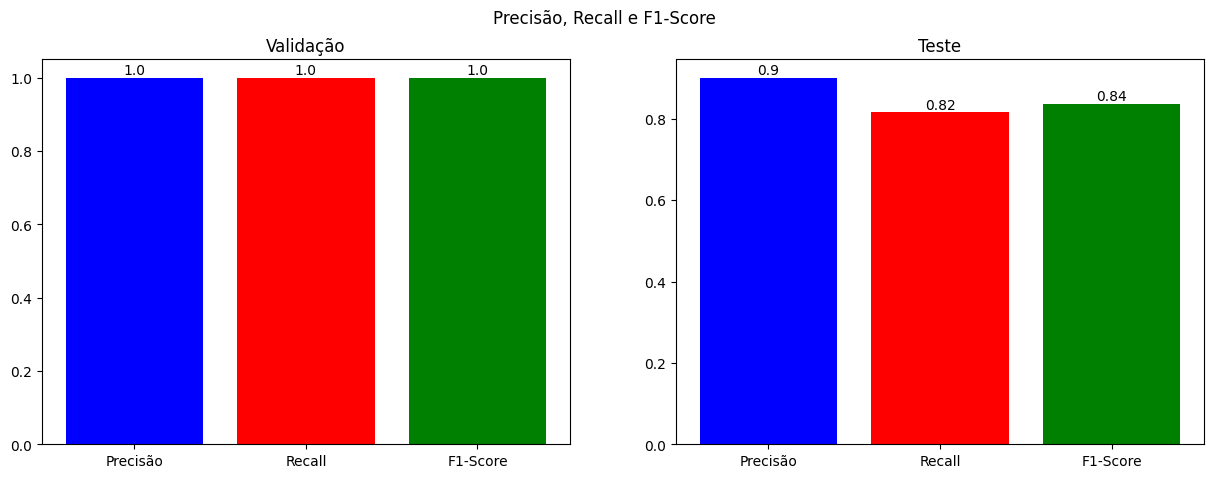

In [75]:
plt.figure(figsize=(15, 5))
plt.suptitle("Precisão, Recall e F1-Score")

# Precisão


def get_precision(predictions, labels):
    # Convertendo rótulos preditos em array categorico
    predictions_classes = np.argmax(predictions, axis=1)

    # Convertendo previsões em array com o maior valor
    Y_true = np.argmax(labels, axis=1)

    # Precisão
    precision = precision_recall_fscore_support(
        Y_true, predictions_classes, average='macro')

    return precision


def plot_precision(predictions, labels, title='Precisão', i=1):
    # Precisão
    precision = get_precision(predictions, labels)

    plt.subplot(1, 2, i)
    plt.bar(['Precisão'], precision[0], color='blue')
    plt.bar(['Recall'], precision[1], color='red')
    plt.bar(['F1-Score'], precision[2], color='green')

    # show value in bar
    plt.text(0, precision[0], round(precision[0], 2), ha='center', va='bottom')
    plt.text(1, precision[1], round(precision[1], 2), ha='center', va='bottom')
    plt.text(2, precision[2], round(precision[2], 2), ha='center', va='bottom')
    plt.title(title)
    return precision


plot_precision(validacao_predictions, validacao_y,
               title='Validação', i=1)
plot_precision(teste_predictions, teste_y,
               title='Teste', i=2)
